In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def algorithm(algoname,colors,train,test,pos):
    mean_tpr,lw,i =0.0, 2,1
    mean_fpr = np.linspace(0, 1, 100)
    fold_accuracy= []
    skfold = StratifiedKFold(n_splits=10,shuffle = True)
    for (trainindex,testindex), color in zip(skfold.split(train, test.values.ravel()), colors):
        X_train, X_test = train.loc[trainindex], train.loc[testindex]
        y_train, y_test = test.loc[trainindex], test.loc[testindex]
        model = algoname.fit(X_train,y_train.values.ravel())
        fold_accuracy.append(model.score(X_test,y_test.values.ravel()))
        result = model.predict(X_test)
        fpr, tpr, thresholds= roc_curve(y_test.values,result,pos_label=pos)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.step(fpr, tpr, lw=lw, color=color,label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i+=1
    mean_tpr /= skfold.get_n_splits(train,test.values.ravel())
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.step(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.title("Average accuracy: {0:.3f}".format(np.asarray(fold_accuracy).mean()))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right") 
    return ("Average accuracy: {0:.3f} (+/-{1:.3f})".format(np.asarray(fold_accuracy).mean(),\
                                                            np.asarray(fold_accuracy).std()))    

In [3]:
import math
import operator
def euclidean_distance(data1,data2):
    result = 0.0
    for val in range(len(data2)):
        result += (data1[val]-data2[val])**2
    return math.sqrt(result)
def knn(train,test,k):
    dist,kneighbors = [],[]
    for a,c in train.iterrows():
        distance = euclidean_distance(c,test)
        dist.append((c,distance))
        dist.sort(key=operator.itemgetter(1))
    for i in range(k):
        kneighbors.append(dist[i][0])
    return kneighbors  
def majorityVote(kneighbors):
    vote = {}
    for i in range(len(kneighbors)):
        lst = kneighbors[i][-1]
        if lst in vote:
            vote[lst]+=1
        else:
            vote[lst]=1
    majority = max(vote.items(), key=operator.itemgetter(1))[0]
    return majority

In [4]:
estimators = [10,100,300,600,800,1000]
depth = [1,2,50,100,300,800,None]
features = ['auto','sqrt',0.2, None]
min_sampleleaf = [1,5,10,50,100,200,500]
randomstate = [1,50,100,500,None]
colors = cycle(['brown','lightcoral','red','magenta','cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
penalties = ['l1','l2']
cvalue = [1.0,0.1,0.5,0.8,0.9]
solve = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
tolerance = []
classweight = ['balanced',None]
max_iter = [10,100,500,1000]
randomState = [None,10,100,500,1000,1024]
neighbors = [5,10,50,100]
weight = ['uniform','distance']
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
dual = [True,False]

In [5]:
crx = pd.read_csv('crx.data',header=None,sep = ',')
cols = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15']
classlabel = ['A16']
columns = cols + classlabel
crx.columns = columns
crx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
A1     690 non-null object
A2     690 non-null object
A3     690 non-null float64
A4     690 non-null object
A5     690 non-null object
A6     690 non-null object
A7     690 non-null object
A8     690 non-null float64
A9     690 non-null object
A10    690 non-null object
A11    690 non-null int64
A12    690 non-null object
A13    690 non-null object
A14    690 non-null object
A15    690 non-null int64
A16    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


In [6]:
for col in crx.columns.values:
    if crx[col].dtype == 'object':
        crx[col] = LabelEncoder().fit_transform(crx[col])
crx_train, crx_test = crx[cols],crx[classlabel]        
crx_test['A16'].value_counts()

1    383
0    307
Name: A16, dtype: int64

# Random Forest Algorithm

Estimators - Number of tress in the forest

Average accuracy: 0.861 (+/-0.030) estimators:  10
Average accuracy: 0.884 (+/-0.024) estimators:  100
Average accuracy: 0.880 (+/-0.038) estimators:  300
Average accuracy: 0.875 (+/-0.034) estimators:  600
Average accuracy: 0.880 (+/-0.018) estimators:  800
Average accuracy: 0.880 (+/-0.031) estimators:  1000


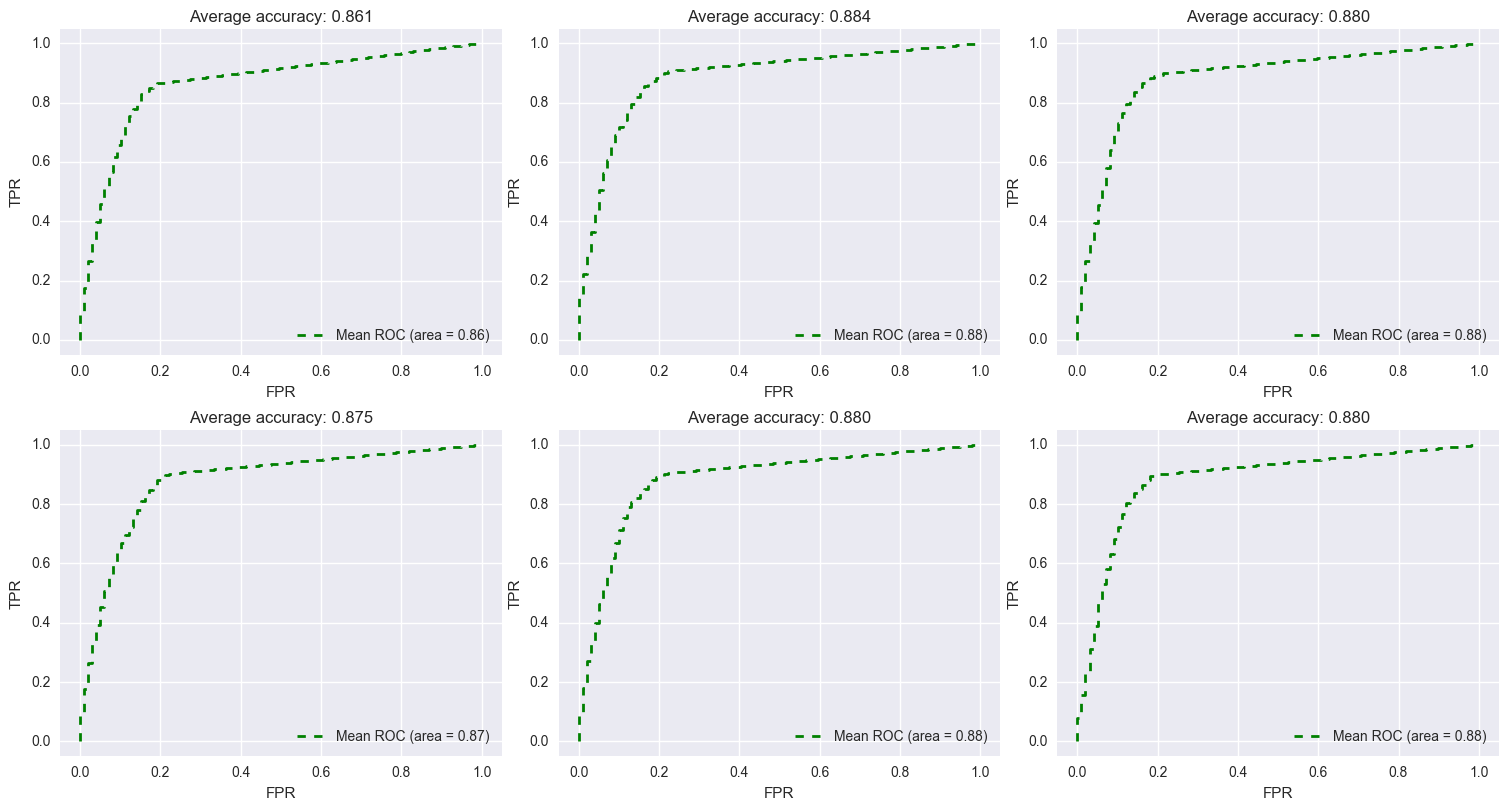

In [7]:
plt.figure(figsize=(15,8))

for i in range(len(estimators)):
    forest = RandomForestClassifier(n_estimators=estimators[i], n_jobs=-1)
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"estimators: ",estimators[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Maximum Depth of Tree

Average accuracy: 0.841 (+/-0.046) Max Depth:  1
Average accuracy: 0.865 (+/-0.032) Max Depth:  2
Average accuracy: 0.880 (+/-0.039) Max Depth:  50
Average accuracy: 0.884 (+/-0.039) Max Depth:  100
Average accuracy: 0.875 (+/-0.046) Max Depth:  300
Average accuracy: 0.874 (+/-0.031) Max Depth:  800
Average accuracy: 0.874 (+/-0.046) Max Depth:  None


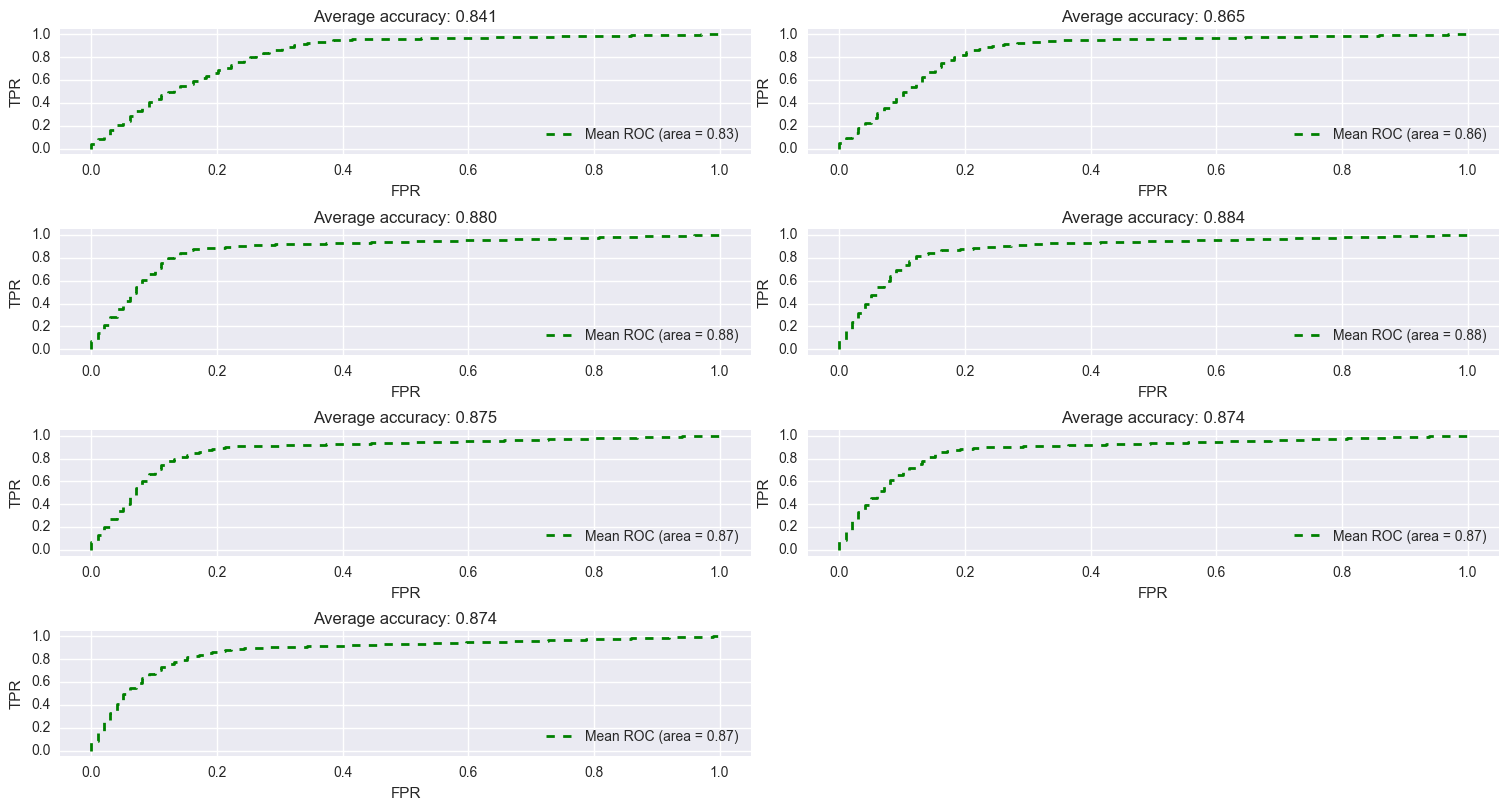

In [8]:
plt.figure(figsize=(15,8))

for i in range(len(depth)):
    forest = RandomForestClassifier(n_estimators=800, n_jobs=-1, max_depth = depth[i])
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"Max Depth: ",depth[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

The number of features to consider when looking for the best split

Average accuracy: 0.877 (+/-0.038) max features:  auto
Average accuracy: 0.878 (+/-0.038) max features:  sqrt
Average accuracy: 0.877 (+/-0.018) max features:  0.2
Average accuracy: 0.868 (+/-0.029) max features:  None


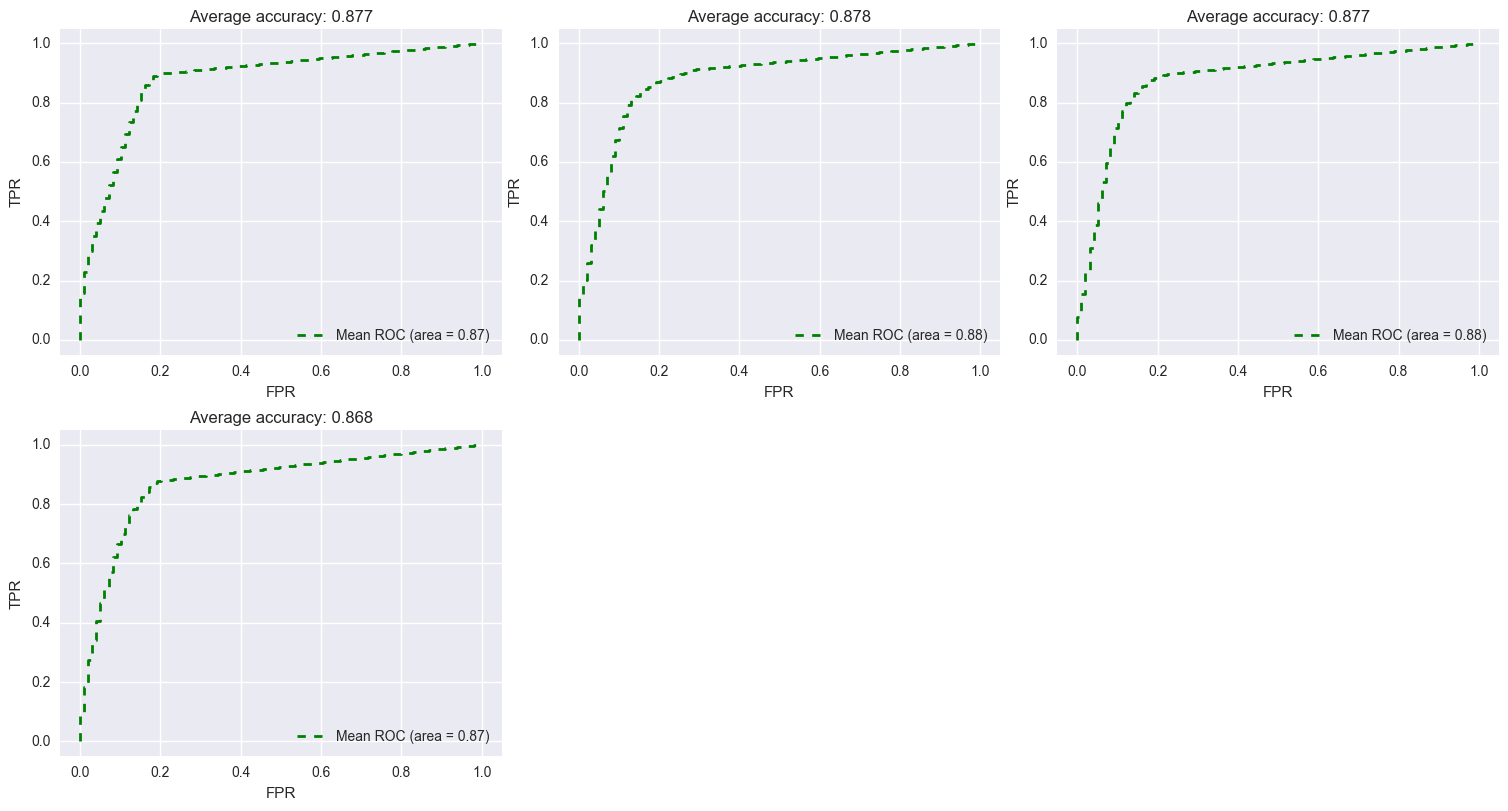

In [9]:
plt.figure(figsize=(15,8))
for i in range(len(features)):
    forest = RandomForestClassifier(n_estimators=800, n_jobs=-1, max_depth = 300,    \
                                    max_features = features[i])
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"max features: ",features[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

the minimum number of samples required to be at a leaf node

Average accuracy: 0.881 (+/-0.039) min sample leaf:  1
Average accuracy: 0.873 (+/-0.045) min sample leaf:  5
Average accuracy: 0.868 (+/-0.050) min sample leaf:  10
Average accuracy: 0.854 (+/-0.054) min sample leaf:  50
Average accuracy: 0.856 (+/-0.047) min sample leaf:  100
Average accuracy: 0.555 (+/-0.004) min sample leaf:  200
Average accuracy: 0.555 (+/-0.004) min sample leaf:  500


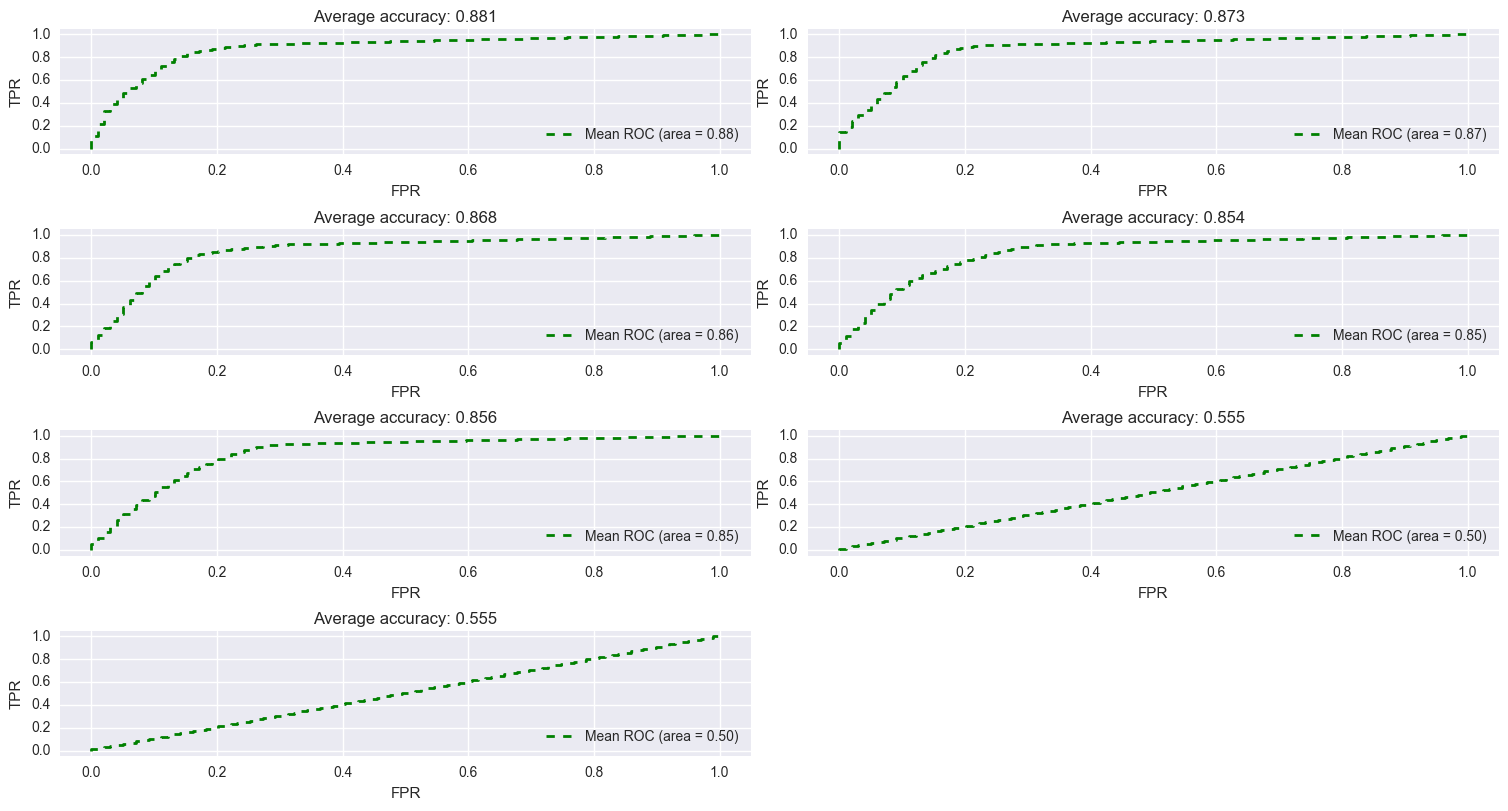

In [10]:
plt.figure(figsize=(15,8))
for i in range(len(min_sampleleaf)):
    forest = RandomForestClassifier(n_estimators=800, n_jobs=-1, max_depth = 300,max_features = 'auto',\
                                    min_samples_leaf =min_sampleleaf[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"min sample leaf: ",min_sampleleaf[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

random_state is the seed used by the random number generator

Average accuracy: 0.872 (+/-0.046) random state:  1
Average accuracy: 0.881 (+/-0.042) random state:  50
Average accuracy: 0.875 (+/-0.041) random state:  100
Average accuracy: 0.878 (+/-0.039) random state:  500
Average accuracy: 0.868 (+/-0.036) random state:  None


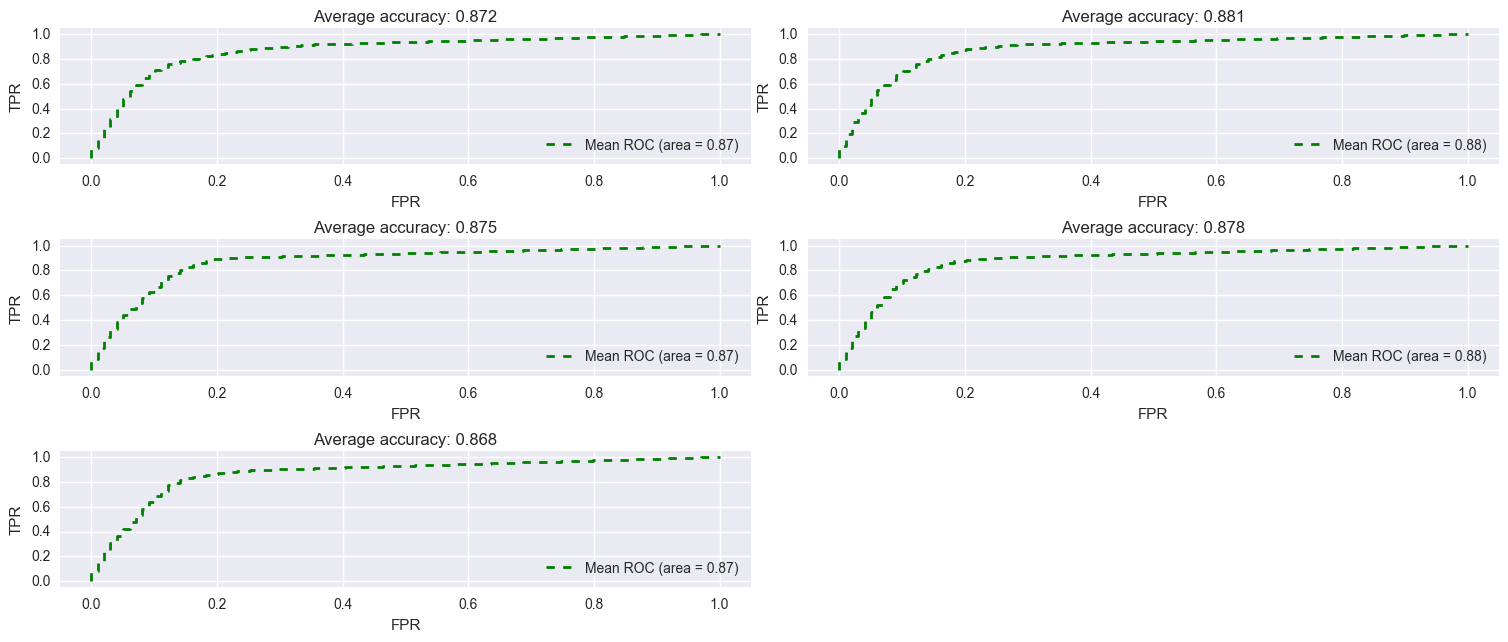

In [11]:
plt.figure(figsize=(15,8))
for i in range(len(randomstate)):
    forest = RandomForestClassifier(n_estimators=800, n_jobs=-1, max_depth = 300,max_features = 'auto',\
                                    min_samples_leaf =1,random_state=randomstate[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"random state: ",randomstate[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Best Parameters using Greedy Approach

Average accuracy: 0.877 (+/-0.032)


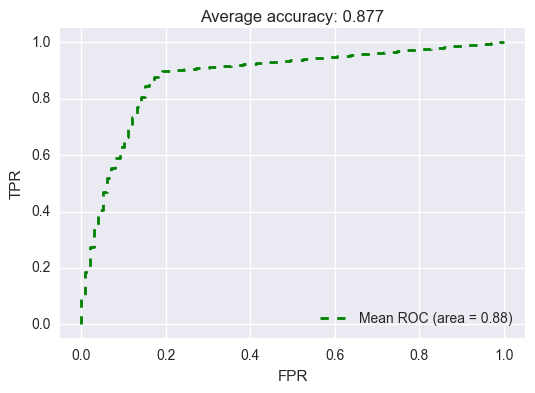

In [12]:
forest = RandomForestClassifier(n_estimators=800, n_jobs=-1, max_depth = 300,max_features = 'auto',\
                                    min_samples_leaf =1,random_state=100)
print(algorithm(forest,colors,crx_train,crx_test,pos = None))

# Logistic Regression

L1 or L2 regularization?

Average accuracy: 0.868 (+/-0.040) Penalty:  l1
Average accuracy: 0.858 (+/-0.030) Penalty:  l2


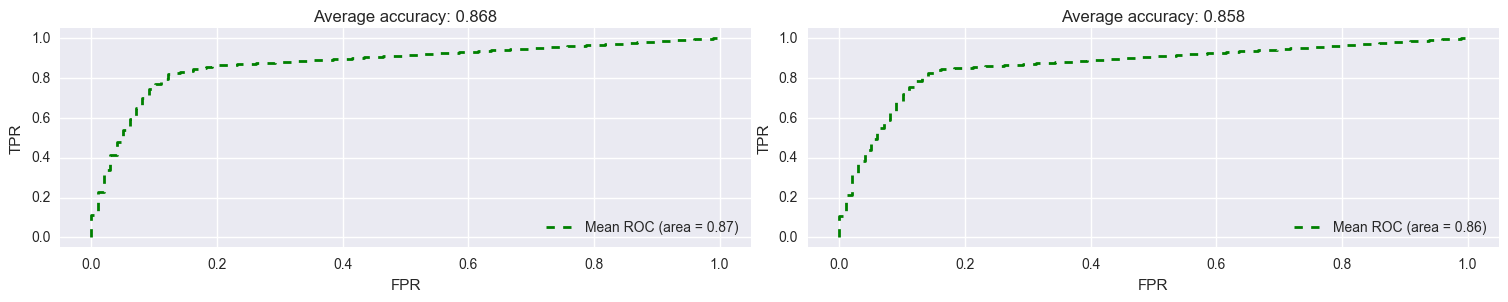

In [13]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    logistic = LogisticRegression(n_jobs = -1, penalty= penalties[i])
    plt.subplot(3,2,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)   

Algorithm to use in the optimization problem?

Average accuracy: 0.867 (+/-0.028) Solver:  newton-cg
Average accuracy: 0.820 (+/-0.030) Solver:  lbfgs
Average accuracy: 0.867 (+/-0.038) Solver:  liblinear
Average accuracy: 0.667 (+/-0.054) Solver:  sag


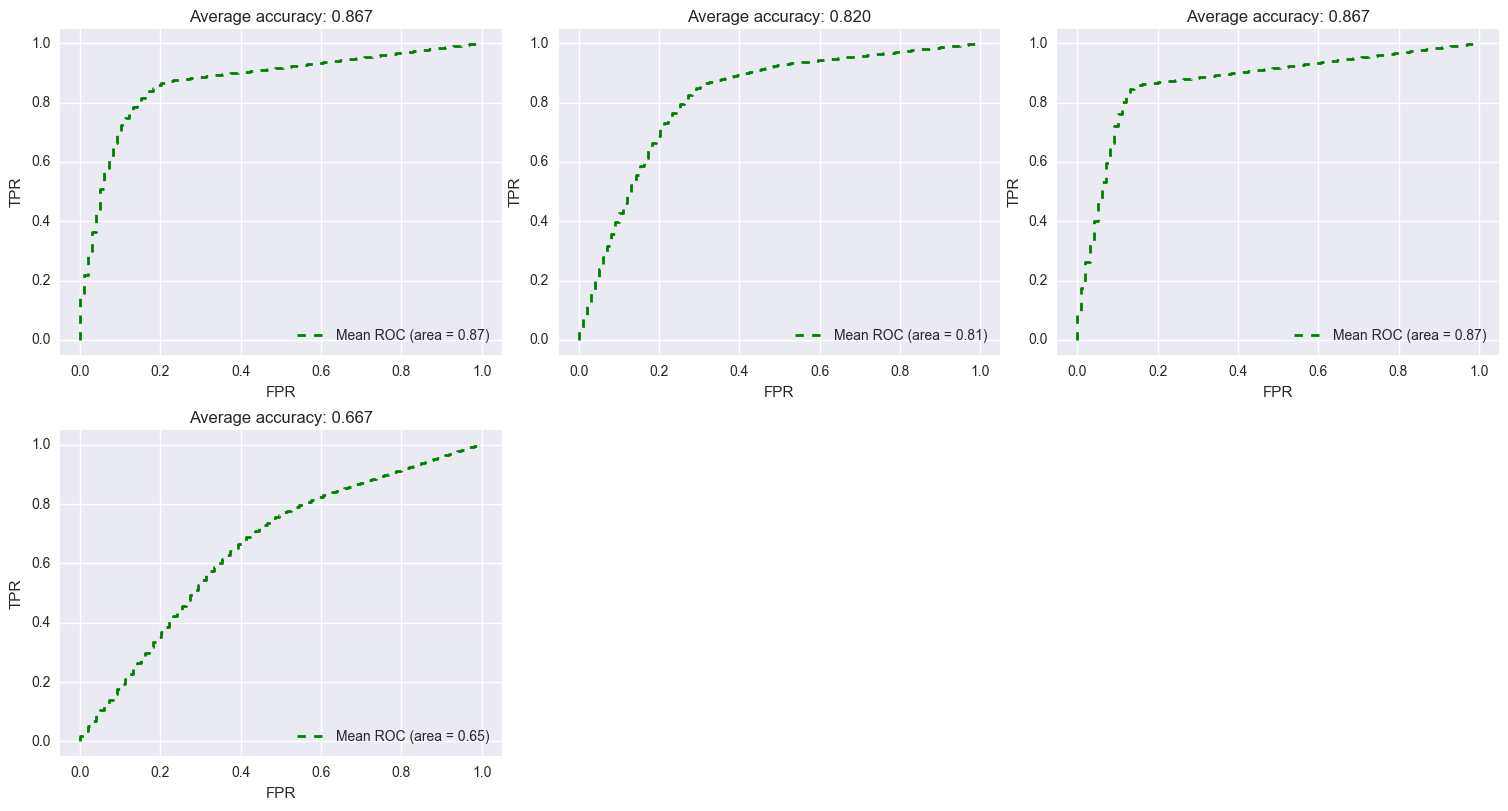

In [14]:
plt.figure(figsize=(15,8))
for i in range(len(solve)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2',  solver = solve[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Solver: ",solve[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

C Value: Inverse of regularization strength

Average accuracy: 0.862 (+/-0.053) C:  1.0
Average accuracy: 0.854 (+/-0.019) C:  0.1
Average accuracy: 0.867 (+/-0.032) C:  0.5
Average accuracy: 0.857 (+/-0.043) C:  0.8
Average accuracy: 0.856 (+/-0.046) C:  0.9


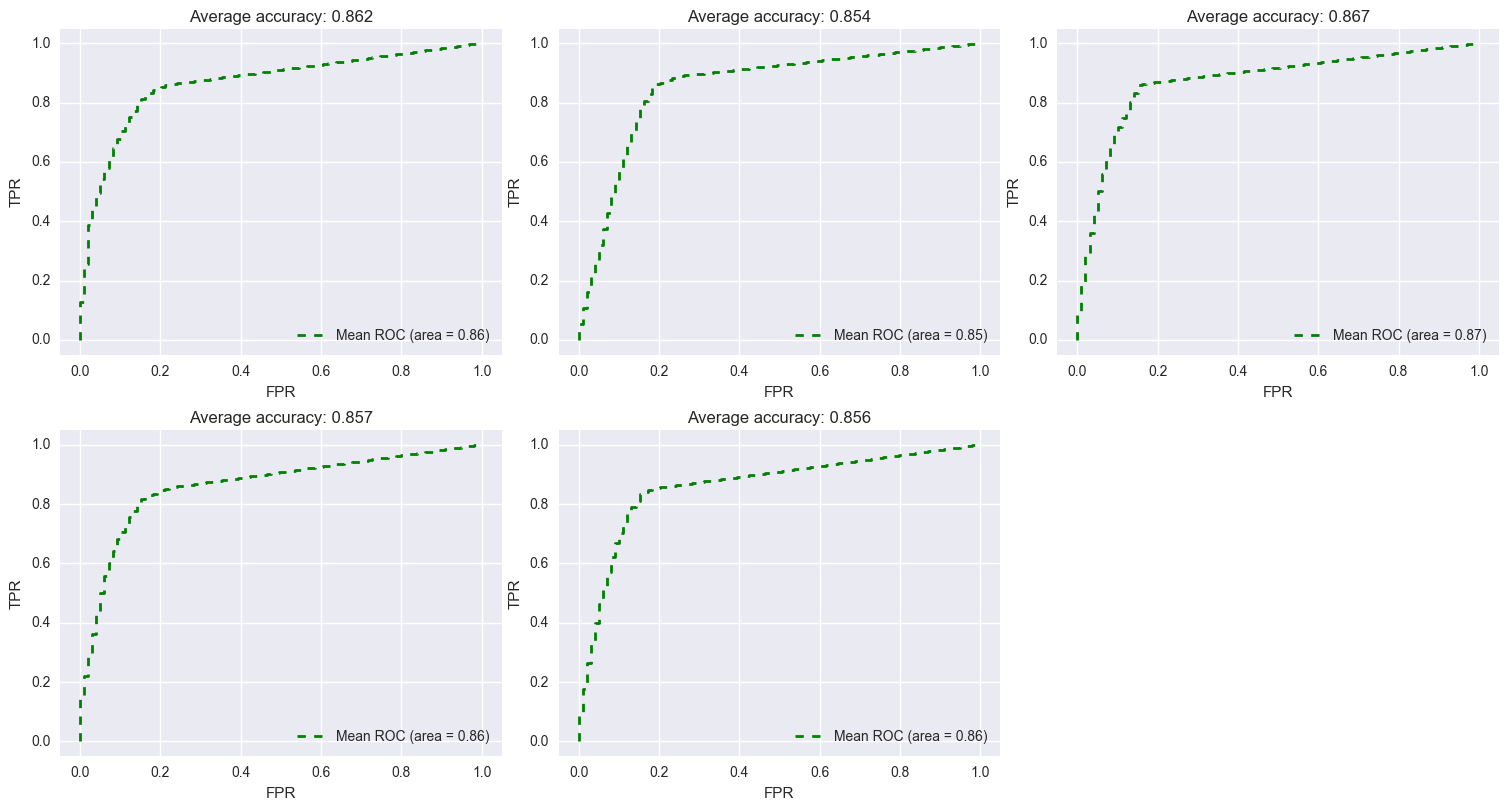

In [15]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', solver = 'liblinear', C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Weights associated with classes

Average accuracy: 0.865 (+/-0.032) Class Weight:  balanced
Average accuracy: 0.859 (+/-0.017) Class Weight:  None


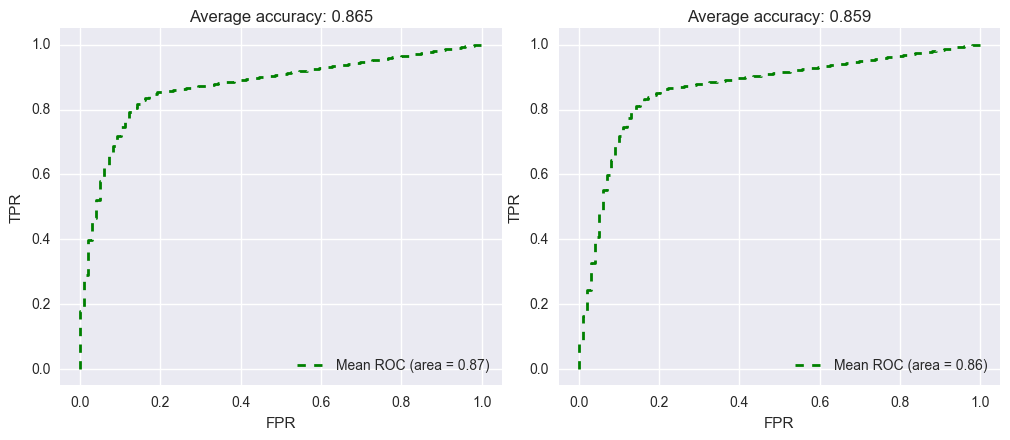

In [16]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 1 , solver = 'liblinear',\
                                  class_weight = classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Maximum Iteration

Average accuracy: 0.674 (+/-0.046) Max iterations:  10
Average accuracy: 0.860 (+/-0.034) Max iterations:  100
Average accuracy: 0.862 (+/-0.032) Max iterations:  500
Average accuracy: 0.868 (+/-0.043) Max iterations:  1000


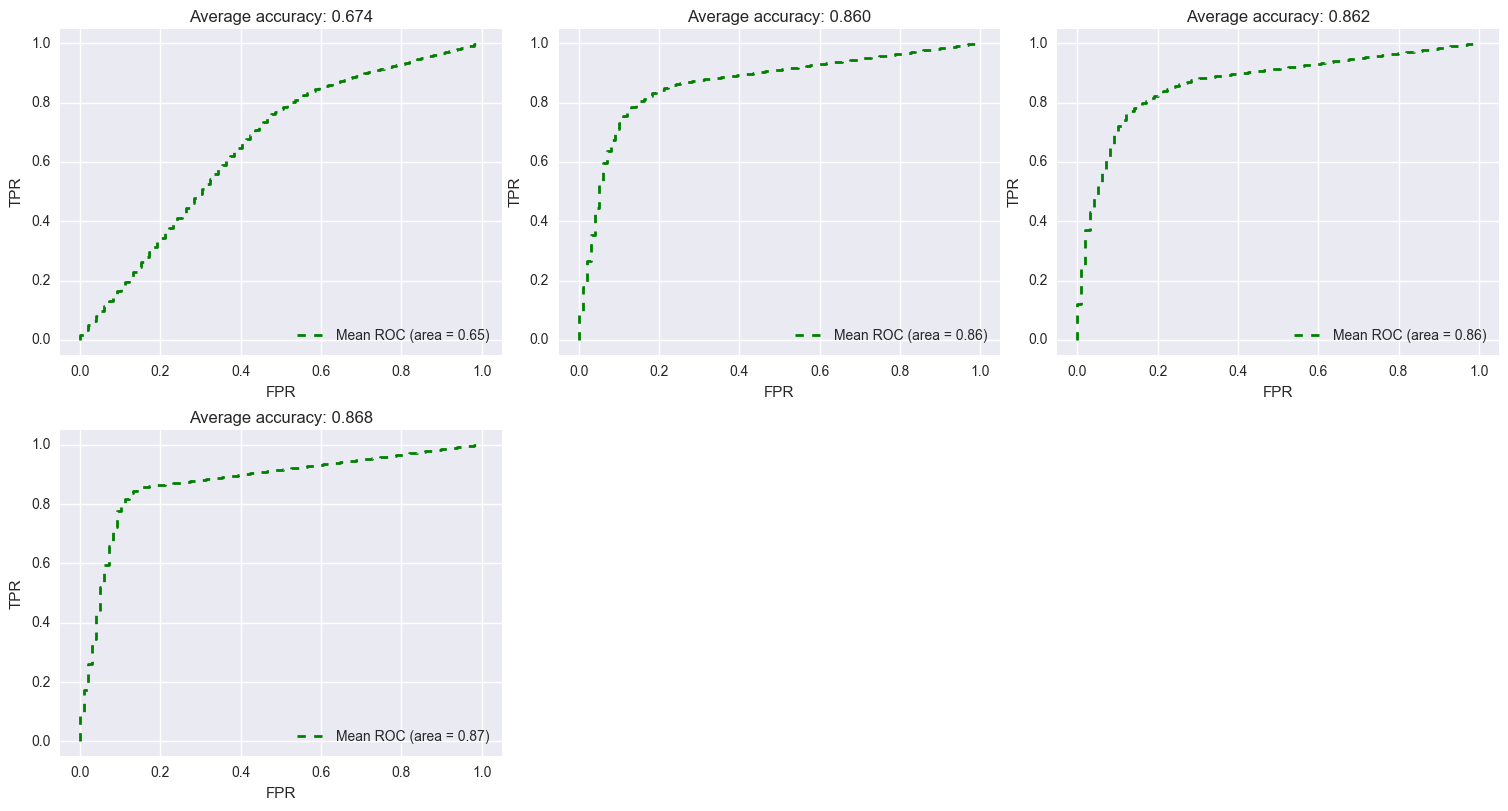

In [17]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 1 , solver = 'liblinear',  \
                                  class_weight = None ,max_iter = max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Max iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

Ignoring Maximum iterations because of two reasons:<br/>
1. Accuracy decreasing <br/>
2. Useful only for the newton-cg, sag and lbfgs solvers

Random State: The seed of the pseudo random number generator to use when shuffling the data

Average accuracy: 0.862 (+/-0.037) Random State:  None
Average accuracy: 0.865 (+/-0.044) Random State:  10
Average accuracy: 0.864 (+/-0.033) Random State:  100
Average accuracy: 0.870 (+/-0.029) Random State:  500
Average accuracy: 0.868 (+/-0.050) Random State:  1000
Average accuracy: 0.868 (+/-0.036) Random State:  1024


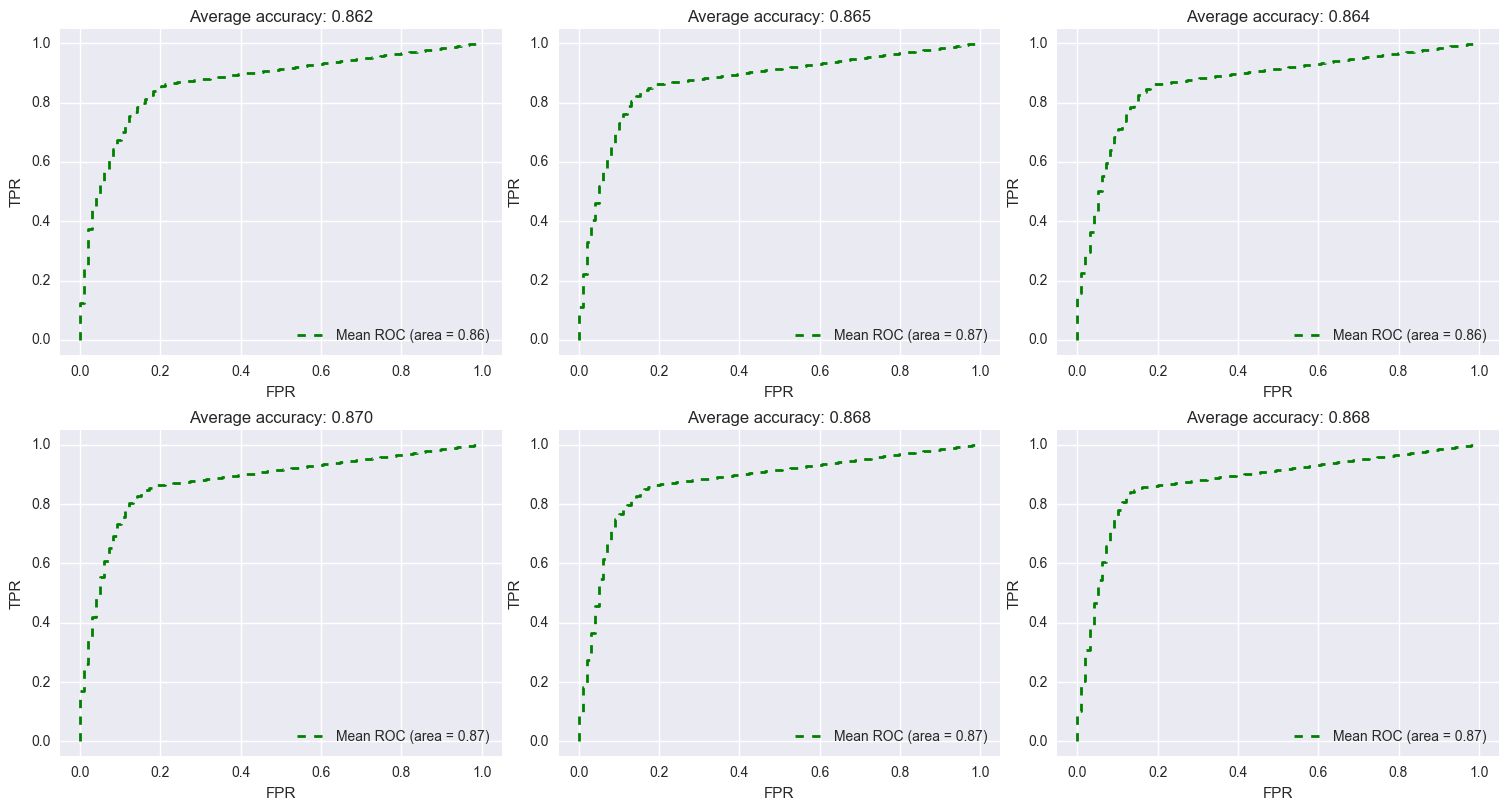

In [18]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 1 , solver = 'liblinear',   \
                                  class_weight = None,random_state = randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

Best Parameters using Greedy Approach

Average accuracy: 0.865 (+/-0.043)


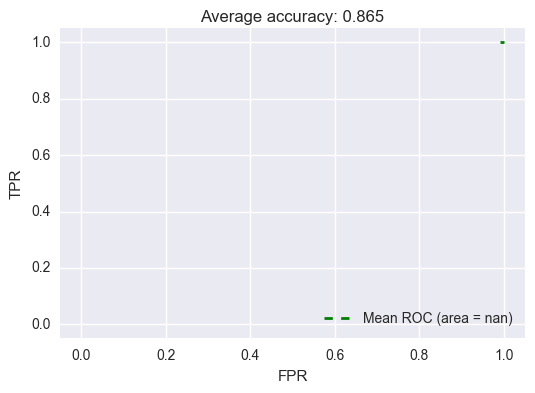

In [19]:
logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 1 , solver = 'liblinear',   \
                                  class_weight = None,random_state = None)
print(algorithm(logistic,colors,crx_train,crx_test,pos = 2))

# Naive Bayes

Average accuracy: 0.787 (+/-0.045)


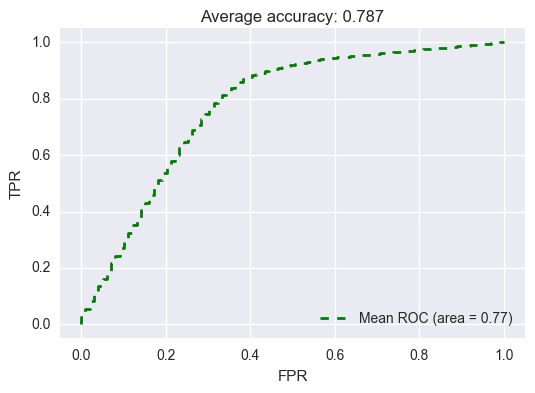

In [20]:
naive = GaussianNB()
print(algorithm(naive,colors,crx_train,crx_test,pos = None))

# k Nearest Neighbors

Number of neighbors

Average accuracy: 0.675 (+/-0.033) Neighbors:  5
Average accuracy: 0.675 (+/-0.061) Neighbors:  10
Average accuracy: 0.677 (+/-0.036) Neighbors:  50
Average accuracy: 0.681 (+/-0.039) Neighbors:  100


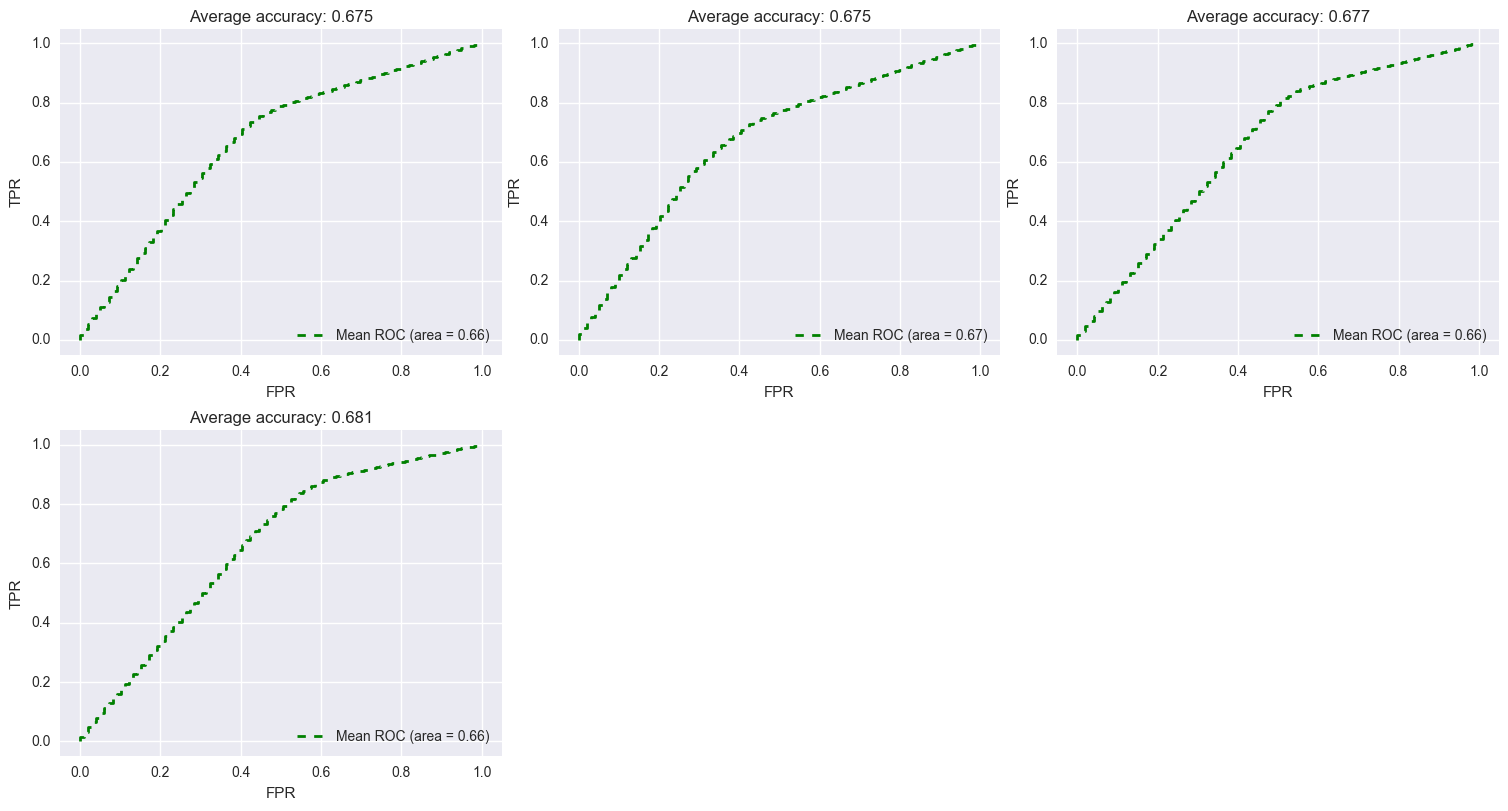

In [21]:
plt.figure(figsize=(15,8))
for i in range(len(neighbors)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors= neighbors[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,crx_train,crx_test,pos = None),"Neighbors: ",neighbors[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

weight function used in prediction

Average accuracy: 0.674 (+/-0.035) Weights:  uniform
Average accuracy: 0.687 (+/-0.041) Weights:  distance


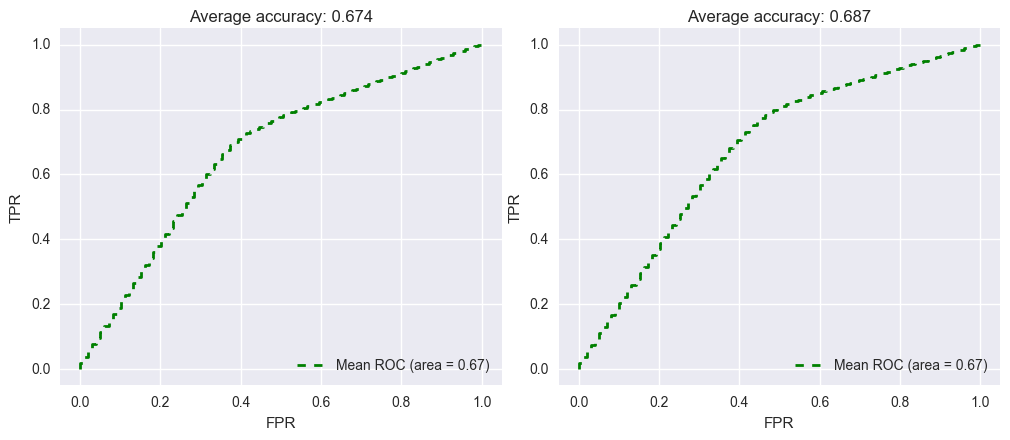

In [22]:
plt.figure(figsize=(15,8))
for i in range(len(weight)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=10, weights = weight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,crx_train,crx_test,pos = None),"Weights: ",weight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Algorithm used to compute the nearest neighbors

Average accuracy: 0.675 (+/-0.037) Algorithm:  auto
Average accuracy: 0.683 (+/-0.053) Algorithm:  ball_tree
Average accuracy: 0.675 (+/-0.070) Algorithm:  kd_tree
Average accuracy: 0.681 (+/-0.037) Algorithm:  brute


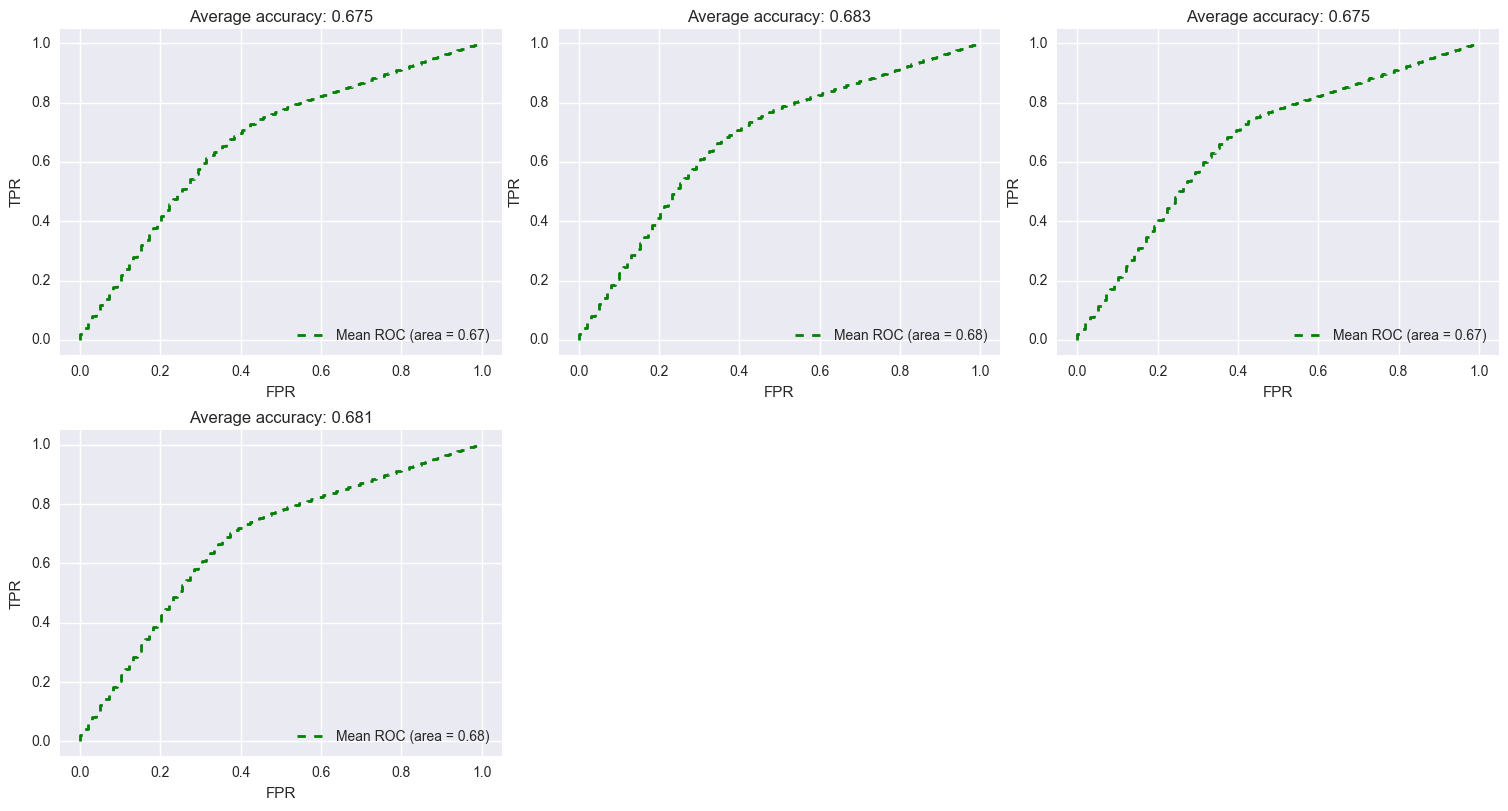

In [23]:
plt.figure(figsize=(15,8))
for i in range(len(algo)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=10, weights = 'uniform', algorithm = algo[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,crx_train,crx_test,pos = None),"Algorithm: ",algo[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Best Parameters using Greedy Approach

Average accuracy: 0.672 (+/-0.048)


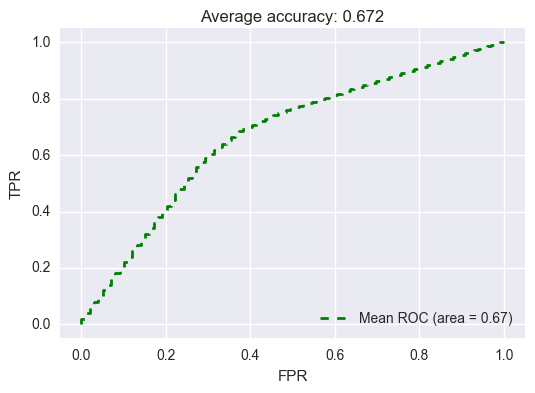

In [24]:
knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=10, weights = 'uniform', algorithm = 'ball_tree')
print(algorithm(knneigh,colors,crx_train,crx_test,pos = None))

# Support Vector Machines

Dual or primal optimization

Average accuracy: 0.729 (+/-0.079) Dual:  True
Average accuracy: 0.858 (+/-0.041) Dual:  False


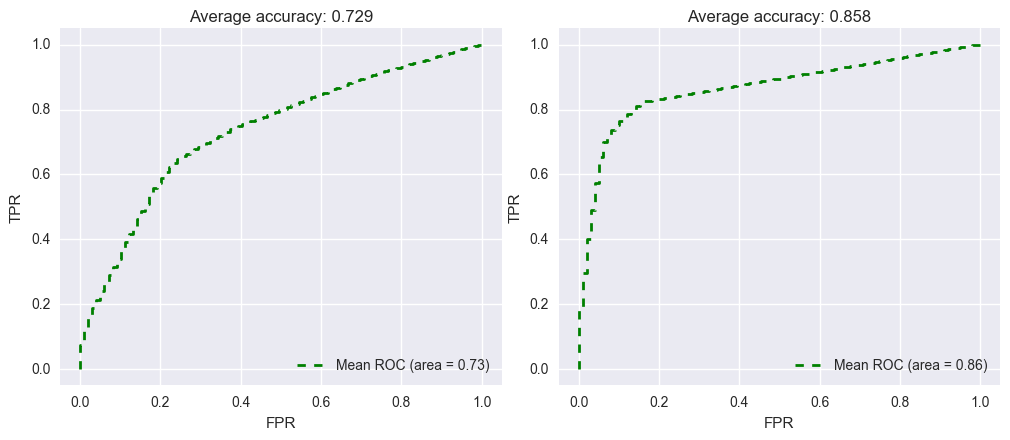

In [25]:
plt.figure(figsize=(15,8))
for i in range(len(dual)):
    svm = LinearSVC(dual = dual[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Dual: ",dual[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

C Value: Inverse of regularization strength

Average accuracy: 0.855 (+/-0.033) C:  1.0
Average accuracy: 0.859 (+/-0.046) C:  0.1
Average accuracy: 0.854 (+/-0.026) C:  0.5
Average accuracy: 0.857 (+/-0.043) C:  0.8
Average accuracy: 0.852 (+/-0.026) C:  0.9


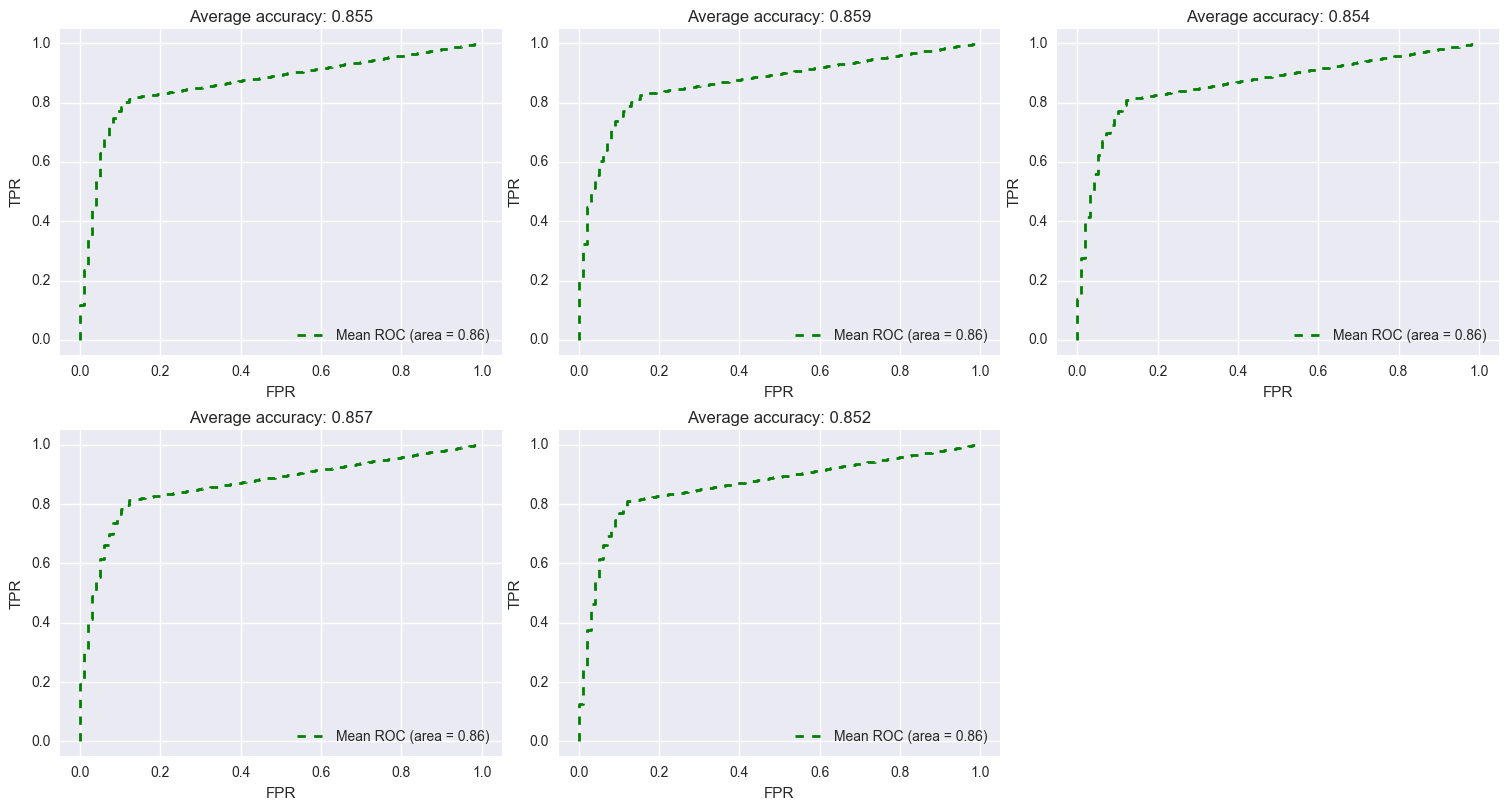

In [26]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    svm = LinearSVC(dual = False, C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

L1 or L2 regularization?

Average accuracy: 0.859 (+/-0.036) Penalty:  l1
Average accuracy: 0.858 (+/-0.034) Penalty:  l2


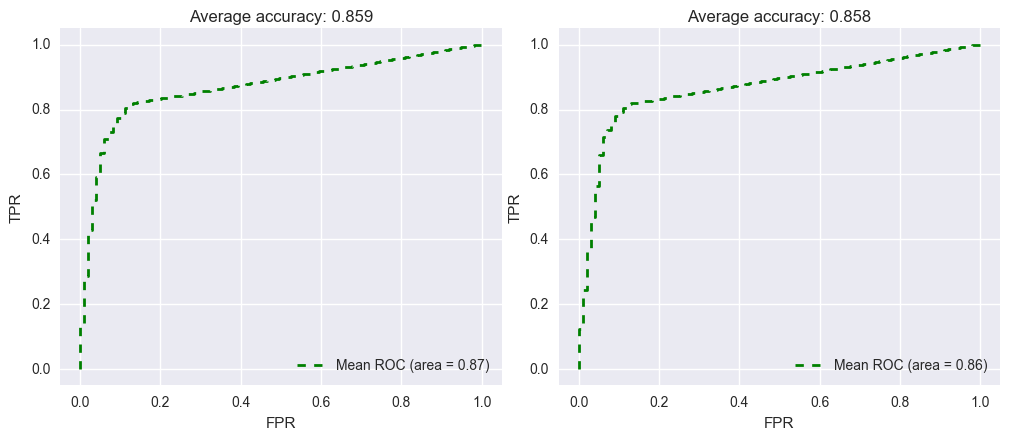

In [27]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    svm = LinearSVC(dual = False, C = 1, penalty = penalties[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

weight function used in prediction

Average accuracy: 0.852 (+/-0.032) Class Weight:  balanced
Average accuracy: 0.854 (+/-0.048) Class Weight:  None


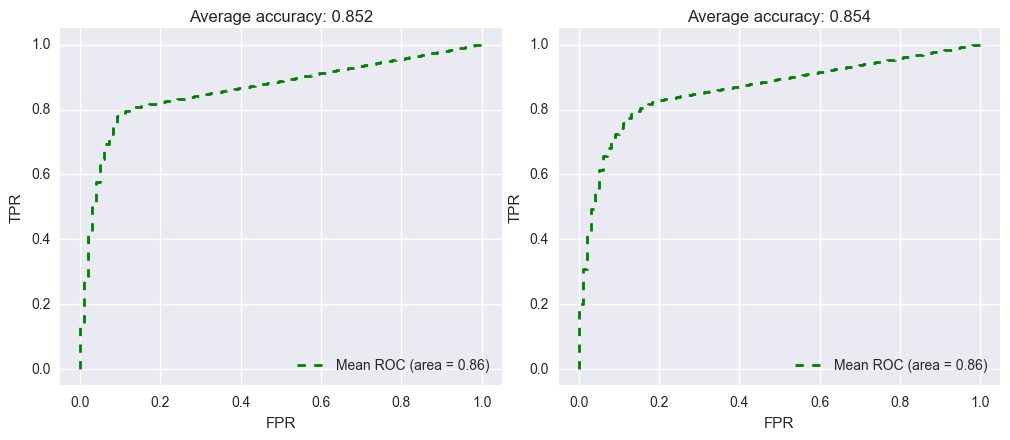

In [28]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l2', class_weight=classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Maximum Iteration

Average accuracy: 0.676 (+/-0.037) Max Iterations:  10
Average accuracy: 0.862 (+/-0.039) Max Iterations:  100
Average accuracy: 0.854 (+/-0.030) Max Iterations:  500
Average accuracy: 0.854 (+/-0.042) Max Iterations:  1000


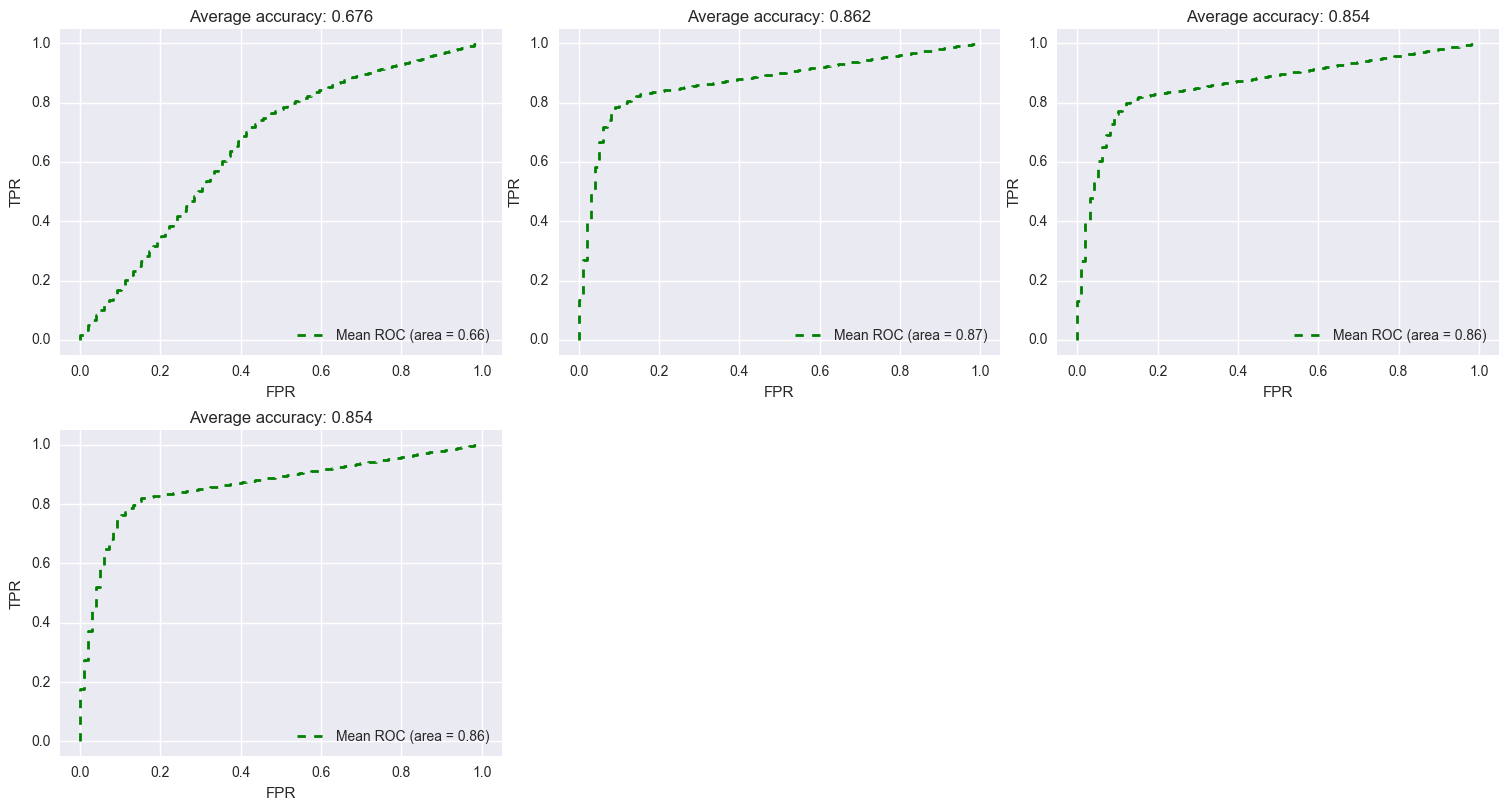

In [29]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l2', class_weight=None,max_iter=max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Max Iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Random State = The seed of the pseudo random number generator to use when shuffling the data.

Average accuracy: 0.857 (+/-0.039) Random State:  None
Average accuracy: 0.860 (+/-0.033) Random State:  10
Average accuracy: 0.858 (+/-0.046) Random State:  100
Average accuracy: 0.855 (+/-0.042) Random State:  500
Average accuracy: 0.860 (+/-0.045) Random State:  1000
Average accuracy: 0.855 (+/-0.025) Random State:  1024


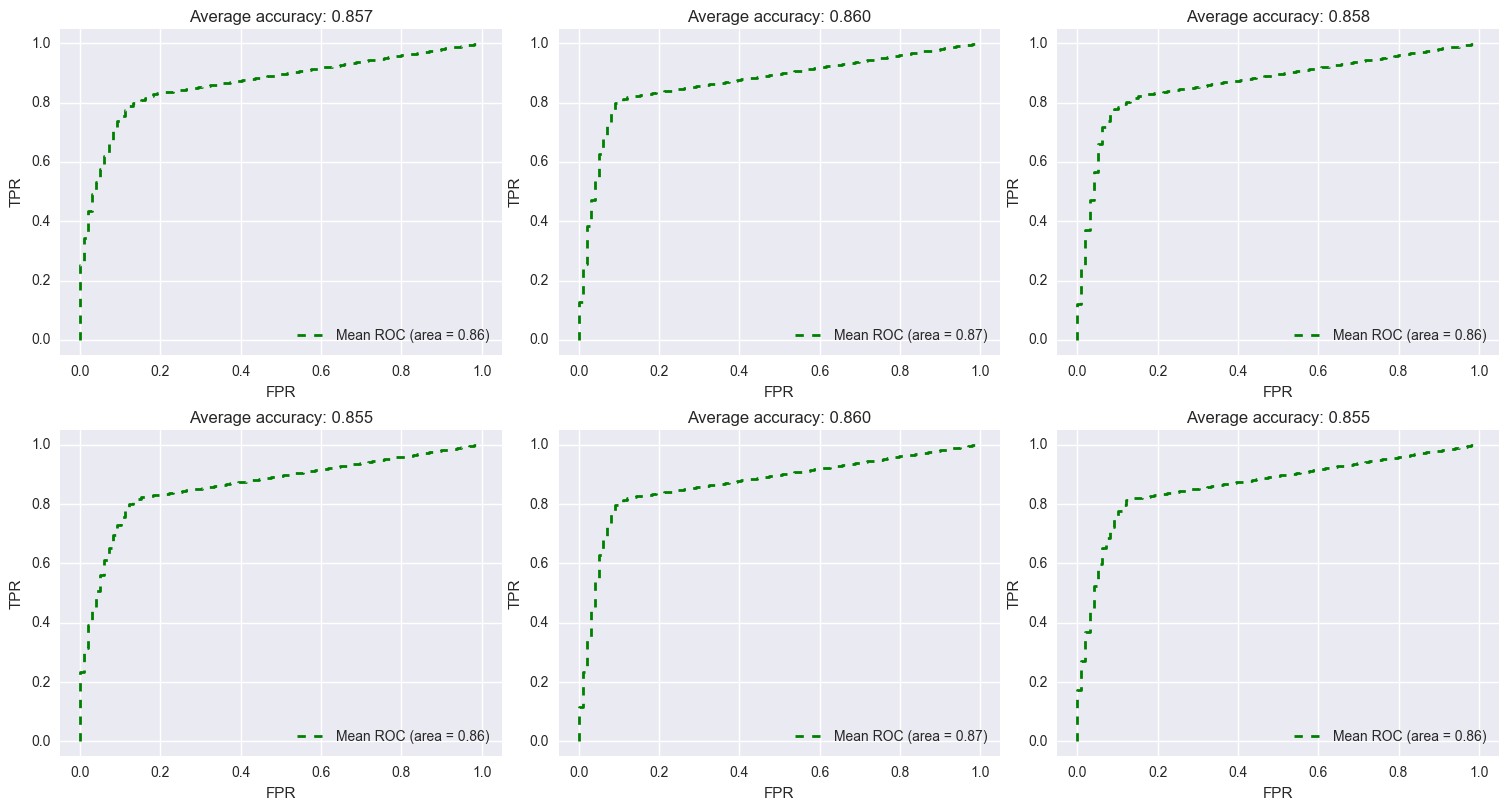

In [30]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l2', class_weight=None,max_iter=500,random_state=randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Best Parameters using Greedy Approach

Average accuracy: 0.857 (+/-0.054)


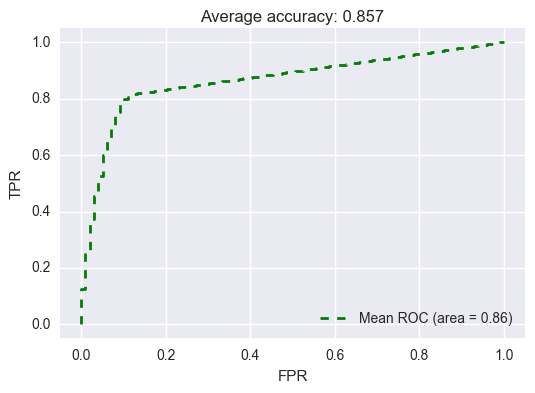

In [31]:
svm = LinearSVC(dual = False, C = 1, penalty = 'l2', class_weight=None,max_iter=500,random_state=1000)
print(algorithm(svm,colors,crx_train,crx_test,pos = None))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(crx.iloc[:,:-1], crx.iloc[:,-1:], test_size=0.20, random_state=4212)
train = pd.concat([X_train, y_train], axis=1)

Our kNN implementation

In [33]:
predictions = []
for i,c in X_test.iterrows():
    neigh = knn(train,c,5)
    responses = majorityVote(neigh)
    predictions.append(responses)
mine_knn = pd.DataFrame( data={"predicted":predictions,"actual":y_test.values.ravel()} ) 
print ("accuracy_score: ", accuracy_score(mine_knn['actual'],mine_knn['predicted']))

accuracy_score:  0.666666666667
